In [1]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
seed = 42

In [3]:
df = pd.read_csv('../data/from_pyupbit/KRW-BTC.csv')

In [4]:
df

,timestamp,open,high,low,close,volume,value
0,2021-10-10 16:17:00,67982000.0,67995000.0,67907000.0,67983000.0,4.421744,3.005567e+08
1,2021-10-10 16:18:00,67983000.0,68000000.0,67953000.0,68000000.0,3.850292,2.618115e+08
2,2021-10-10 16:19:00,68000000.0,68010000.0,68000000.0,68007000.0,3.077483,2.092768e+08
3,2021-10-10 16:20:00,68007000.0,68007000.0,68000000.0,68003000.0,4.067062,2.765715e+08
4,2021-10-10 16:21:00,68003000.0,68004000.0,67888000.0,67888000.0,8.721608,5.929939e+08
...,...,...,...,...,...,...,...
1576795,2024-10-12 16:24:00,84592000.0,84593000.0,84592000.0,84593000.0,0.659041,5.575006e+07
1576796,2024-10-12 16:25:00,84593000.0,84593000.0,84587000.0,84593000.0,0.912152,7.716141e+07
1576797,2024-10-12 16:26:00,84593000.0,84599000.0,84589000.0,84599000.0,1.912721,1.618046e+08
1576798,2024-10-12 16:27:00,84599000.0,84620000.0,84595000.0,84620000.0,0.547881,4.635441e+07


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [6]:
df

,open,high,low,close,volume,value
timestamp,,,,,,
2021-10-10 16:17:00,67982000.0,67995000.0,67907000.0,67983000.0,4.421744,3.005567e+08
2021-10-10 16:18:00,67983000.0,68000000.0,67953000.0,68000000.0,3.850292,2.618115e+08
2021-10-10 16:19:00,68000000.0,68010000.0,68000000.0,68007000.0,3.077483,2.092768e+08
2021-10-10 16:20:00,68007000.0,68007000.0,68000000.0,68003000.0,4.067062,2.765715e+08
2021-10-10 16:21:00,68003000.0,68004000.0,67888000.0,67888000.0,8.721608,5.929939e+08
...,...,...,...,...,...,...
2024-10-12 16:24:00,84592000.0,84593000.0,84592000.0,84593000.0,0.659041,5.575006e+07
2024-10-12 16:25:00,84593000.0,84593000.0,84587000.0,84593000.0,0.912152,7.716141e+07
2024-10-12 16:26:00,84593000.0,84599000.0,84589000.0,84599000.0,1.912721,1.618046e+08


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))
joblib.dump(scaler, 'models/KRW-BTC_scaler.pkl')

['models/bitcoin_scaler.pkl']

In [8]:
timestep = 1

In [9]:
X = []
y = []
for i in range(len(scaled_data) - timestep - 1):
    X.append(scaled_data[i:(i + timestep), 0])
    y.append(scaled_data[i + timestep, 0])

In [10]:
X, y = np.array(X), np.array(y)

In [11]:
train_size = int(len(X) * .8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [12]:
train_dates = df.index[:train_size]
test_dates = df.index[train_size:]

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [14]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [17]:
model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/20
39420/39420 [==============================] - 331s 8ms/step - loss: 5.8463e-05 - val_loss: 2.3595e-06
Epoch 2/20
39420/39420 [==============================] - 397s 10ms/step - loss: 9.2433e-07 - val_loss: 5.7405e-06
Epoch 3/20
39420/39420 [==============================] - 425s 11ms/step - loss: 7.5381e-07 - val_loss: 2.2386e-06
Epoch 4/20
39420/39420 [==============================] - 426s 11ms/step - loss: 6.5751e-07 - val_loss: 5.9060e-07
Epoch 5/20
39420/39420 [==============================] - 429s 11ms/step - loss: 6.1214e-07 - val_loss: 1.8547e-06
Epoch 6/20
39420/39420 [==============================] - 428s 11ms/step - loss: 5.4875e-07 - val_loss: 1.9436e-06
Epoch 7/20
39420/39420 [==============================] - 443s 11ms/step - loss: 5.0752e-07 - val_loss: 1.2878e-06
Epoch 8/20
39420/39420 [==============================] - 426s 11ms/step - loss: 4.9579e-07 - val_loss: 1.1163e-06
Epoch 9/20
39420/39420 [==============================] - 398s 10ms/step - loss: 

In [18]:
model.save('models/lstm_KRW-BTC.h5')

In [19]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9855/9855 [==============================] - 33s 3ms/step


In [20]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [21]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

Train RMSE: 49055.19
Test RMSE: 122450.03


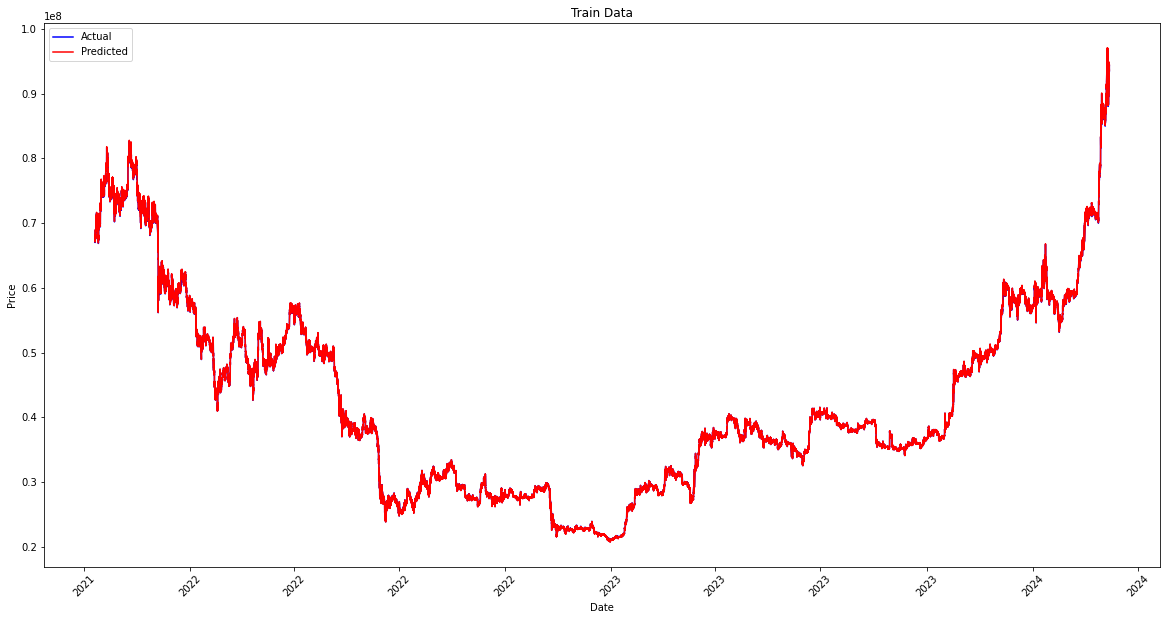

In [22]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.plot(train_dates, y_train[0], label='Actual', color = 'Blue')
plt.plot(train_dates, train_predict, label='Predicted', color = 'Red')
plt.title('Train Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

In [ ]:
plt.subplot(1, 1, 1)
plt.plot(test_dates[:-2], y_test[0], label='Actual', color = 'Blue')
plt.plot(test_dates[:-2], test_predict, label='Predicted', color = 'Red')
plt.title('Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [24]:
last_1_day = scaled_data[-timestep:]
X_predict = last_1_day.reshape(1, timestep, 1)
print(last_1_day)

[[0.78192931]]


In [25]:
pred = model.predict(X_predict)
pred = scaler.inverse_transform(pred)
print(pred)

1/1 [==============================] - 0s 12ms/step
[[82900992.]]
